<a href="https://colab.research.google.com/github/erikrosen01/SSL-using-PaCMAP/blob/main/Food101_sample_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import datasets
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from glob import glob
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 205MB/s]
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_linear4_head.pth" to /root/.cache/torch/hub/che

100%|██████████| 5.00G/5.00G [04:11<00:00, 19.9MB/s]


Extracting food101/food-101.tar.gz to food101


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

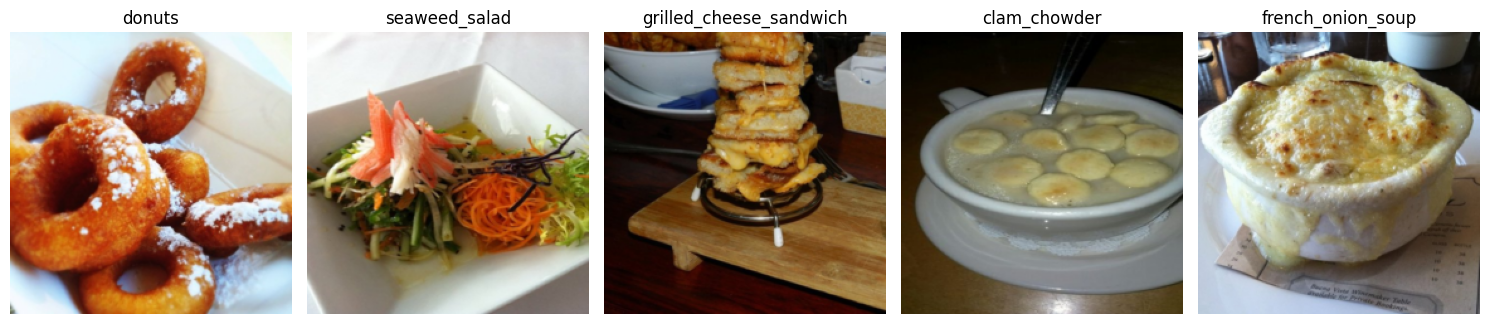

In [3]:
batch_size = 1
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors and normalize to [0, 1]
])

train_data = torchvision.datasets.Food101(root='food101', split='train', download=True, transform=transform)
test_data = torchvision.datasets.Food101(root='food101', split='test', download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# Randomly select 5 samples
random_indices = random.sample(range(len(train_data)), 5)
samples = [train_data[idx] for idx in random_indices]

# Plot the samples
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(samples):
    axs[i].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
    axs[i].axis('off')  # Turn off axes
    axs[i].set_title(train_data.classes[label])  # Set the title to the class name

plt.tight_layout()
plt.show()

In [4]:
from torch.utils.data import Subset
batch_size = 16

class_is_taken = {}
one_sample_per_class = []
class_to_index = {}

idx_list = list(range(len(train_data)))
random.shuffle(idx_list)

for i in range(len(idx_list)):
    idx = idx_list[i]
    _, label = train_data[idx]
    if label not in class_to_index:
        class_to_index[label] = idx
    if len(class_to_index) == len(train_data.classes):
        break

subset_indices = list(class_to_index.values())
small_train_subset = Subset(train_data, subset_indices)
small_train_loader = DataLoader(small_train_subset, batch_size=batch_size, shuffle=True)

for idx, data_index in enumerate(subset_indices):
    _, label = train_data[data_index]
    print(f"Class: {train_data.classes[label]}, Index: {data_index}")


Class: apple_pie, Index: 13228
Class: cheese_plate, Index: 58969
Class: lobster_bisque, Index: 51225
Class: filet_mignon, Index: 55447
Class: hot_and_sour_soup, Index: 1225
Class: tuna_tartare, Index: 57082
Class: garlic_bread, Index: 32792
Class: creme_brulee, Index: 24273
Class: chicken_curry, Index: 36332
Class: ravioli, Index: 48247
Class: bibimbap, Index: 11280
Class: grilled_salmon, Index: 35726
Class: ramen, Index: 9796
Class: pizza, Index: 68078
Class: chocolate_mousse, Index: 62095
Class: sashimi, Index: 2373
Class: ice_cream, Index: 71708
Class: croque_madame, Index: 43857
Class: panna_cotta, Index: 4663
Class: donuts, Index: 46856
Class: shrimp_and_grits, Index: 54707
Class: gnocchi, Index: 22911
Class: pulled_pork_sandwich, Index: 10959
Class: cheesecake, Index: 70644
Class: greek_salad, Index: 6625
Class: bread_pudding, Index: 21362
Class: macaroni_and_cheese, Index: 31363
Class: gyoza, Index: 47486
Class: edamame, Index: 30440
Class: fried_rice, Index: 45890
Class: dumpli

In [5]:
batch_size = 16

class_to_indices = {}

idx_list = list(range(len(train_data)))
random.shuffle(idx_list)

for i in range(len(idx_list)):
    idx = idx_list[i]
    _, label = train_data[idx]
    if label not in class_to_indices:
        class_to_indices[label] = []
    if len(class_to_indices[label]) < 10:
        class_to_indices[label].append(idx)
    if all(len(indices) == 10 for indices in class_to_indices.values()):
        break

subset_indices = list(class_to_index.values())
small_train_subset_10 = Subset(train_data, subset_indices)
small_train_loader_10 = DataLoader(small_train_subset_10, batch_size=batch_size, shuffle=True)

# for idx, data_index in enumerate(subset_indices):
#     _, label = train_data[data_index]
#     print(f"Class: {train_data.classes[label]}, Index: {data_index}")


In [23]:
print(len(test_data))
test_subst_indices = list(range(len(test_data)))

random.shuffle(test_subst_indices)
test_subset_indices = test_subst_indices[:int(len(test_data)/40)]

test_data_subset = Subset(test_data, test_subset_indices)
test_loader_subset = DataLoader(test_data_subset, batch_size=batch_size, shuffle=False)

25250


In [37]:
# Inspect the current classification head
existing_head = dinov2_vits14_lc.linear_head

# Get the shape of the existing head
input_features = existing_head.in_features
output_features = existing_head.out_features

# Initialize a new classification head with random weights
new_head = nn.Linear(input_features, 101)

print(f"New head initialized with shape: {input_features} -> {output_features}")
import copy

# Deep copy the model
dinov2_vits14_lc_original = copy.deepcopy(dinov2_vits14_lc)
dinov2_vits14_lc.linear_head = new_head

frozen_backbone = False

if frozen_backbone:
    # freeze all weights in the dinov2_vits14_lc_copy except the new head
    for param in dinov2_vits14_lc.parameters():
        param.requires_grad = False

    # unfreeze the new head
    for param in dinov2_vits14_lc.linear_head.parameters():
        param.requires_grad = True

# save_checkpoint('/checkpoints',dinov2_vits14_lc,0)

New head initialized with shape: 1920 -> 101


In [26]:
def test_accuracy(model,test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    batches = len(test_loader)
    with torch.no_grad():
        batch = 0
        progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for batch_idx, (images, labels) in progress_bar:
          optimizer.zero_grad()
          # input = processor(images=batch[0], return_tensors="pt")
          input = processor(images=images, return_tensors="pt", padding=True).to(device)
          # input = processor(images=batch[0], return_tensors="pt").to(device)
          labels = labels.to(device)
          output = model(input["pixel_values"])
          loss = loss_function(output, labels)


          # Update running loss and accuracy
          running_loss += (loss.item()-running_loss)/(batch_idx+1)
          _, predicted = output.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()
          acc = correct/total

          # Update progress bar with loss
          progress_bar.set_postfix(loss=running_loss,accuracy=f"{100*acc:.2f}%")
    return acc

In [38]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14_lc.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dinov2_vits14_lc.linear_head.parameters(), lr=1e-3)
epochs = 100
epoch = 0

# train_loader = small_train_loader
# train_loader = small_train_loader_10

test_accuracy_list = []

for i in range(epochs):
    dinov2_vits14_lc.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {i+1}/{epochs}")
    for idx, (images, labels) in progress_bar:
        optimizer.zero_grad()
        # input = processor(images=batch[0], return_tensors="pt")
        input = processor(images=images, return_tensors="pt", padding=True).to(device)
        # input = processor(images=batch[0], return_tensors="pt").to(device)
        labels = labels.to(device)
        output = dinov2_vits14_lc(input["pixel_values"])
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item(),accuracy=f"{100*correct/total:.2f}%")
        progress_bar.update(1)


    #print(f"Epoch {i + 1}, Loss: {loss_val.item()}")
    if i == 5 or i % 10 == 0:
        test_acc = test_accuracy(dinov2_vits14_lc,test_loader_subset)
        print(f"Epoch {i + 1}, Test Accuracy: {test_acc}")
        test_accuracy_list.append(test_acc)
        # if test_acc == max(test_accuracy_list):
        #     save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,i,is_best=True)
        # else:
        #     save_checkpoint(dinov2_vits14_lc,optimizer,loss_function,test_acc,i)


100%|██████████| 40/40 [00:09<00:00,  4.17it/s, accuracy=1.11%, loss=5.85]


Epoch 1, Test Accuracy: 0.011093502377179081


100%|██████████| 40/40 [00:10<00:00,  3.96it/s, accuracy=1.90%, loss=5.76]


Epoch 6, Test Accuracy: 0.01901743264659271


100%|██████████| 40/40 [00:10<00:00,  3.91it/s, accuracy=2.38%, loss=6.24]


Epoch 11, Test Accuracy: 0.02377179080824089


100%|██████████| 40/40 [00:10<00:00,  3.86it/s, accuracy=2.69%, loss=6.69]


Epoch 21, Test Accuracy: 0.02694136291600634


100%|██████████| 40/40 [00:10<00:00,  3.94it/s, accuracy=2.38%, loss=7.03]


Epoch 31, Test Accuracy: 0.02377179080824089


100%|██████████| 40/40 [00:10<00:00,  3.86it/s, accuracy=2.85%, loss=7.19]


Epoch 41, Test Accuracy: 0.028526148969889066


100%|██████████| 40/40 [00:10<00:00,  3.93it/s, accuracy=2.85%, loss=7.29]


Epoch 51, Test Accuracy: 0.028526148969889066


100%|██████████| 40/40 [00:10<00:00,  3.96it/s, accuracy=2.54%, loss=7.46]


Epoch 61, Test Accuracy: 0.025356576862123614


100%|██████████| 40/40 [00:10<00:00,  3.88it/s, accuracy=2.38%, loss=7.58]


Epoch 71, Test Accuracy: 0.02377179080824089


100%|██████████| 40/40 [00:10<00:00,  3.96it/s, accuracy=2.38%, loss=7.68]


Epoch 81, Test Accuracy: 0.02377179080824089


100%|██████████| 40/40 [00:10<00:00,  3.88it/s, accuracy=2.38%, loss=7.77]


Epoch 91, Test Accuracy: 0.02377179080824089


Epoch 100/100: 100%|██████████| 7/7 [00:01<00:00,  4.63it/s, accuracy=100.00%, loss=0.0298]


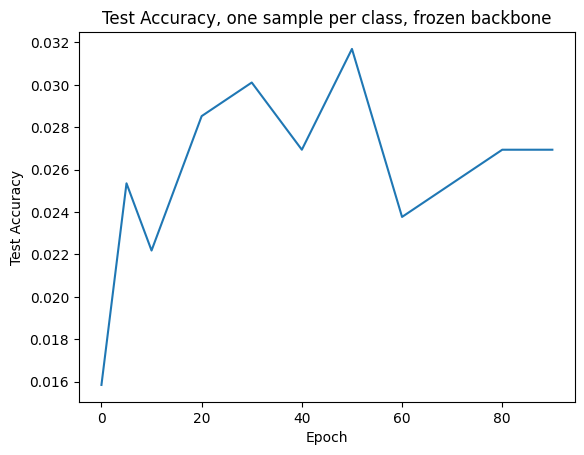

In [33]:
x = [0,5,10,20,30,40,50,60,70,80,90]
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, one sample per class, frozen backbone")
plt.savefig("one_sample_per_class_frozen_backbone.png")
plt.show()

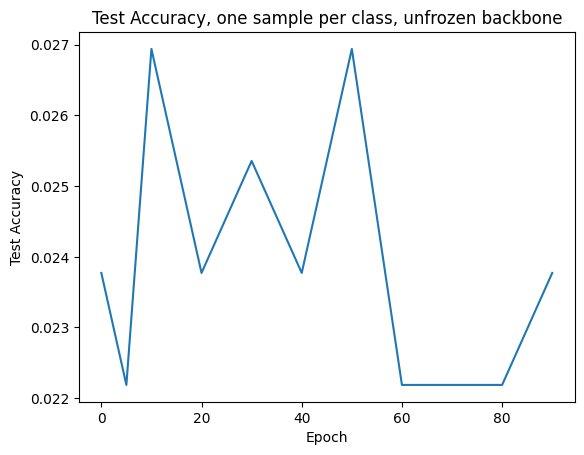

In [30]:
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, one sample per class, unfrozen backbone")
plt.savefig("one_sample_per_class_unfrozen_backbone.png")
plt.show()

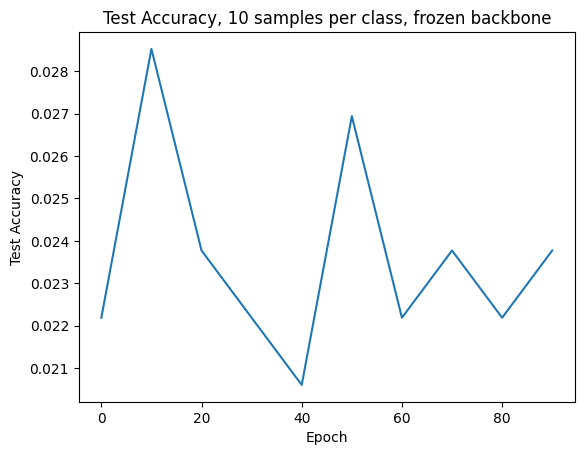

In [36]:
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, 10 samples per class, frozen backbone")
plt.savefig("10_samples_per_class_frozen_backbone.png")
plt.show()

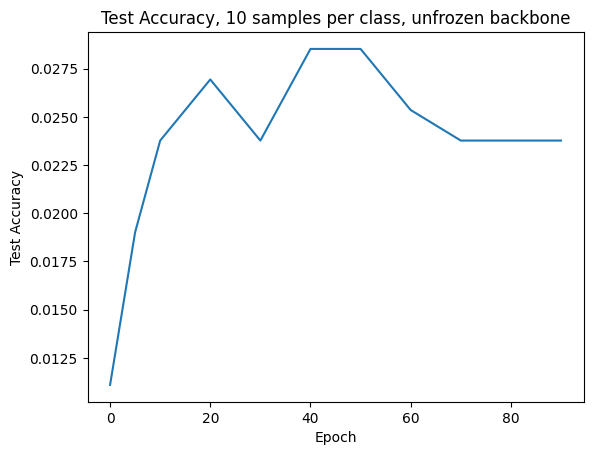

In [40]:
plt.plot(x, test_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy, 10 samples per class, unfrozen backbone")
plt.savefig("10_samples_per_class_unfrozen_backbone.png")
plt.show()